In [56]:
import time
import datetime
import json
import os
import random
import numpy as np
import webbrowser
from PIL import Image
import matplotlib.pyplot as plt
from rich.progress import track
import subprocess
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import Dataset
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

In [57]:
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.Grayscale(),
    transforms.PILToTensor()])


In [58]:
train_dataset = ImageFolder(root="pics_with_coords", transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

In [59]:
class LinNet(nn.Module):
    def __init__(self):
        super(LinNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(64 * 64, 512),
            nn.SiLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.model(x)

In [60]:
data_iter = iter(train_dataloader)
data = next(data_iter)

x, _ = data
x = x.float()


In [ ]:
model = LinNet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
filenames = [train_dataloader.dataset.imgs[i][0].split('/')[-1] for i in range(len(train_dataset))]
len(filenames)

In [ ]:
lat_scaler = MinMaxScaler(feature_range=(-1, 1))
lon_scaler = MinMaxScaler(feature_range=(-1, 1))

img_num = 1 

lat = train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-2]
lon = train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-1]

filename = train_dataloader.dataset.imgs[img_num][0].split('/')[-1]

lat_scaler.fit(np.array([[-90], [90]]))
lon_scaler.fit(np.array([[-180], [180]]))

lat = np.array([[float(lat)]])
lon = np.array([[float(lon)]])
scaled_lat = lat_scaler.transform(lat)
scaled_lon = lon_scaler.transform(lon)
inv_scaled_lat = lat_scaler.inverse_transform(scaled_lat)
inv_scaled_lon = lon_scaler.inverse_transform(scaled_lon)

print(filename)
print(lat, lon)
print(scaled_lat, scaled_lon)
print(inv_scaled_lat, inv_scaled_lon)

In [ ]:
model = model.to("mps")
loss_list = []
for num, image in enumerate(filenames):
    '''
    1. Extract lat and lon
    2. Scale lat and lon to (-1, 1)
    3. Make Tensor for criterion
    4. Load image and apply transformations
    '''
    for param in model.parameters():
                    param.grad = None

    lat = train_dataloader.dataset.imgs[num][0].strip(".png").split("_")[-2]
    lon = train_dataloader.dataset.imgs[num][0].strip(".png").split("_")[-1]
    lat = np.array([[float(lat)]])
    lon = np.array([[float(lon)]])
    scaled_lat = lat_scaler.transform(lat)
    scaled_lon = lon_scaler.transform(lon)
    # print(lat, scaled_lat)
    # print(lon, scaled_lon)
    target = torch.Tensor([scaled_lat[0], scaled_lon[0]])
    target = target.to("mps")
    img = Image.open(os.path.join('pics_with_coords/all', image))
    img_tensor = transforms(img)
    img_tensor = img_tensor.float()
    img_tensor = img_tensor.view(-1)
    img_tensor = img_tensor.to("mps")

    output = model(img_tensor)
    output = output.view(-1, 1)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    # if num == 2000:
            # break
    
    '''print("Target: ", target)
    output = model(img_tensor)
    output = output.view(-1, 1)
    print("Output:", output)
    # print(img_tensor.size())'''


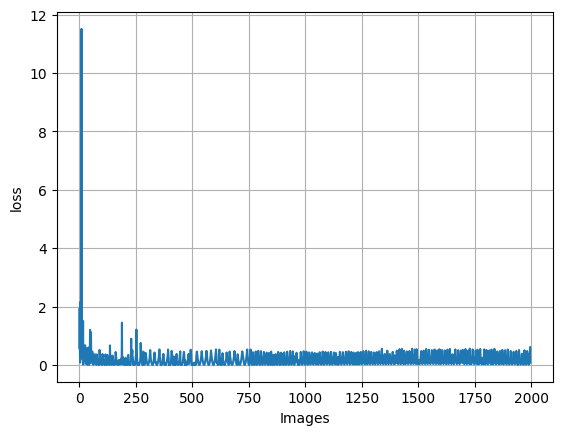

tensor([[-0.0401],
        [ 0.0052]], device='mps:0', grad_fn=<ViewBackward0>)
tensor([[-0.1881],
        [ 0.3781]], device='mps:0')
epic_RGB_20160218075805_-16.92627_68.063965.png


In [69]:

plt.plot(loss_list)
plt.xlabel("Images")
plt.ylabel("loss")
plt.grid()
plt.show()
print(output)
print(target)
print(image)

In [70]:
with torch.no_grad():
    model.eval()

    # Select random picture
    img_num = random.randint(0, len(train_dataloader.dataset))

    # Construct path
    path = train_dataloader.dataset.imgs[img_num][0]
    test_img = Image.open(train_dataloader.dataset.imgs[img_num][0])
    test_img = transforms(test_img)
    test_img = test_img.float()
    test_img = test_img.view(-1)
    test_img = test_img.to("mps")

    output = model(test_img)
    


    lat = train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-2]
    lon = train_dataloader.dataset.imgs[img_num][0].strip(".png").split("_")[-1]
    filename = train_dataloader.dataset.imgs[img_num][0].split('/')[-1]

    lat_scaler.fit(np.array([[-90], [90]]))
    lon_scaler.fit(np.array([[-180], [180]]))

    lat = np.array([[float(lat)]])
    lon = np.array([[float(lon)]])



    print(output)
    print(lat, lon)

    


tensor([-0.0316,  0.0893], device='mps:0')
[[1.582031]] [[145.17334]]


In [ ]:
    # set up orthographic map projection with
    # perspective of satellite looking down at 45N, 100W.
    # use low resolution coastlines.
    map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
    # draw coastlines, country boundaries, fill continents.
    map.drawcoastlines(linewidth=0.25)
    map.drawcountries(linewidth=0.25)
    map.fillcontinents(color='coral',lake_color='aqua')
    # draw the edge of the map projection region (the projection limb)
    map.drawmapboundary(fill_color='aqua')
    # draw lat/lon grid lines every 30 degrees.
    map.drawmeridians(np.arange(0,360,30))
    map.drawparallels(np.arange(-90,90,30))



    plt.title('contour lines over filled continent background')
    plt.show()

